# Retrieving, Processing, and Visualizing Ensemble Precipitation Forecasts from ICON

This notebook walks through the full process of accessing, processing, and visualizing raw forecast data from the ICON numerical weather model, published by MeteoSwiss as part of Switzerland’s Open Government Data (OGD) initiative.

---

##  **What You’ll Do in This Notebook**

1. ️  **Retrieve**  

    Use the OGD API to fetch ensemble forecast data (e.g., total precipitation from the ICON model).

2. 離  **Deaggregate**  

    Convert accumulated precipitation into stepwise values — for example, calculate 1-hour totals from cumulative forecasts.

3. 吝  **Regrid**  

    Transform the data from ICON’s native grid to a regular latitude/longitude grid.

4.   **Visualize**  

    Use Earthkit-Plot to display the processed data on a map, with intuitive color scales and geographic context.

---

## Retrieving Precipitation Forecast
In this first part, we retrieve precipitation forecast data from the ICON numerical weather model. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://sys-data.int.bgdi.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### :folder emoticone: Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;:clip-emoticon: [ICON-CH1 collection](https://sys-data.int.bgdi.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)  

&nbsp;&nbsp;&nbsp;&nbsp;:clip-emoticon: [ICON-CH2 collection](https://sys-data.int.bgdi.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2 collection as seen in the STAC browser interface.


In [11]:
from pathlib import Path
import xarray as xr
import numpy as np
import os
os.environ["ECCODES_DIR"] = str(Path.home()) + "/micromamba/envs/eccodes_env"


from meteodatalab import ogd_api
from meteodatalab.operators import time_operators as time_ops


### Creating Requests
We create a list of requests to fetch the amout of total precipitation (TOT_PREC) from a specific reference time. Each request refers to a different lead time. In this case the lead time denotes the amount of precipitation from the reference time (begin of forecast) to the point in time of the lead time.

>❗ **NOTE**: The collections only contain forecast model data from the last **24 hours**.

In [16]:
amount_of_lead_times = 3
reqlist = []

for i in range(amount_of_lead_times):

    req = ogd_api.Request(
        collection="ogd-forecasting-icon-ch2",
        variable="TOT_PREC",
        reference_datetime="2025-03-21T00:00:00Z",
        perturbed=True,
        horizon="P0DT" + str(i) + "H",
    )
    reqlist.append(req)

Each parameter in the request body serves the following purpose:

- `collections`: Defines the forecast model to use (ICON-CH1-EPS or ICON-CH2-EPS).
- `variable`: Indicates the meteorological parameter of interest (TOT_PREC for total precipitation, for example).
- `reference_datetime`: Specifies the desired forecast initialization time (e.g., 2025-03-20T00:00Z).
- `perturbed`: Boolean flag determining if the data is deterministic (false) or ensemble-based.
- `horizon`: Defines the lead time of the forecast in ISO 8601 duration format (P0DT1H loads data one hour after the reference time).

### Retrieving Data
Use the function `get_from_ogd` to retrieve the required data sets in Xarray format.

In [17]:
ds_list = []

for req in reqlist:
    ds = ogd_api.get_from_ogd(req)
    ds_list.append(ds)

Earthkit-data caching is recommended. See: https://earthkit-data.readthedocs.io/en/latest/examples/cache.html
Earthkit-data caching is recommended. See: https://earthkit-data.readthedocs.io/en/latest/examples/cache.html                                                                 
Earthkit-data caching is recommended. See: https://earthkit-data.readthedocs.io/en/latest/examples/cache.html                                                               


## Data Preprocessing

Once the data has been loaded, continue with the preprocessing of the data.

### Concatinating Lead Times
Add the different lead times to one Xarray data set.

In [18]:
tot_prec_ds = xr.concat(ds_list, dim="lead_time")
tot_prec_ds

<xarray.DataArray (eps: 20, ref_time: 1, lead_time: 3, cell: 283876)> Size: 68MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 160B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
  * ref_time    (ref_time) datetime64[ns] 8B 2025-03-21
  * lead_time   (lead_time) timedelta64[ns] 24B 00:00:00 01:00:00 02:00:00
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 24B 2025-03-21 ... 2025-...
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500041, 'shortName': 'TOT_PRE...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

### Data Aggregation
Aggregate precipitation over one-hour intervals.

In [19]:
prec_eps_1h = time_ops.delta(tot_prec_ds, np.timedelta64(1,"h"))
prec_eps_1h

<xarray.DataArray (eps: 20, ref_time: 1, lead_time: 3, cell: 283876)> Size: 68MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       ...,


       [[[nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 160B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
  * ref_time    (ref_time) datetime64[ns] 8B 2025-03-21
  * lead_time   (lead_time) timedelta64[ns] 24B 00:00:00 01:00:00 02:00:00
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 24B 2025-03-21 ... 2025-...
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500401, 'shortName': 'TOT_PRE...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

### Ensemble Calculation
Compute median ensembles using the preprocessed data and chose the desired lead time.

In [20]:
prec_avg = prec_eps_1h.isel(lead_time=2).median(dim="eps").clip(min=0)
prec_avg.attrs = prec_eps_1h.attrs
prec_avg

<xarray.DataArray (ref_time: 1, cell: 283876)> Size: 1MB
array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * ref_time    (ref_time) datetime64[ns] 8B 2025-03-21
    lead_time   timedelta64[ns] 8B 02:00:00
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time) datetime64[ns] 8B 2025-03-21T02:00:00
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500401, 'shortName': 'TOT_PRE...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

### Regridding Data
In order to regrid your data to a regulare grid import the libraries below and use the function `regrid`.

In [21]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

xmin = -0.817
ymin = 41.183
xmax = 18.183
ymax = 51.183
nx = 950
ny = 500

destination = regrid.RegularGrid(
    CRS.from_string("epsg:4326"), nx, ny, xmin,xmax, ymin,ymax)

prec_avg_geo = regrid.iconremap(prec_avg, destination)

## Plotting Data
Finally, the data is visualised using earthkit.

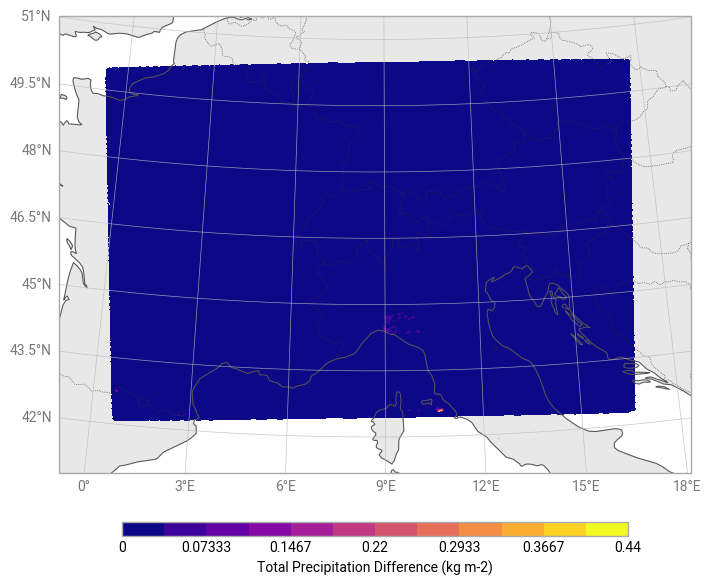

In [22]:
from earthkit.plots.geo import domains
import earthkit

icon_ch2_domain = domains.Domain.from_bbox(bbox=[xmin, xmax, ymin, ymax], name="CH2")
chart = earthkit.plots.Map(domain=icon_ch2_domain)

chart.block(prec_avg_geo, x="lon", y="lat")
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()
chart.legend(label=f"{prec_avg_geo.attrs['parameter']['name']} ({prec_avg_geo.attrs['parameter']['units']})")
chart.show()